In [19]:
import numpy as np
np.random.seed(123)  # for reproducibility
 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage.feature
import pandas as pd
%matplotlib inline

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0],28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [5]:
# Define normal CNN model
model = Sequential()
 
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               589952    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 600,810
Trainable params: 600,810
Non-trainable params: 0
_________________________________________________________________


In [6]:
# define fully convolutional model
model2 = Sequential()
 
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(None,None,1)))
model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(128, (12, 12), activation='relu'))
model2.add(Conv2D(10, (1, 1), activation='softmax'))

In [8]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, None, None, 32)    320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 128)   589952    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 10)    1290      
Total params: 600,810
Trainable params: 600,810
Non-trainable params: 0
_________________________________________________________________


In [82]:
# load previous trained model for normal cnn
model = keras.models.load_model('./saved/mnist_normal_model.hdf5')

In [111]:
# assign weights to fully convolutional model
model2.layers[0].set_weights(model.layers[0].get_weights())
model2.layers[1].set_weights(model.layers[1].get_weights())
first = model.layers[4].get_weights()[0].reshape(12,12,32,128)
second = model.layers[4].get_weights()[1]
model2.layers[3].set_weights([first, second])
first = model.layers[5].get_weights()[0].reshape(1,1,128,10)
second = model.layers[5].get_weights()[1]
model2.layers[4].set_weights([first, second])

In [84]:
test_images = [0,0,0,0]
test_images[0] = X_test[4]
test_images[1] = X_test[11]
test_images[2] = X_test[129]
test_images[3] = np.zeros(X_test[1].shape)

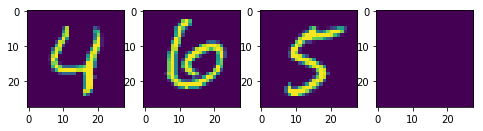

In [85]:
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 1
for i in range(1,5):
    fig.add_subplot(rows, columns, i)
    plt.imshow(test_images[i-1].squeeze())
plt.show()

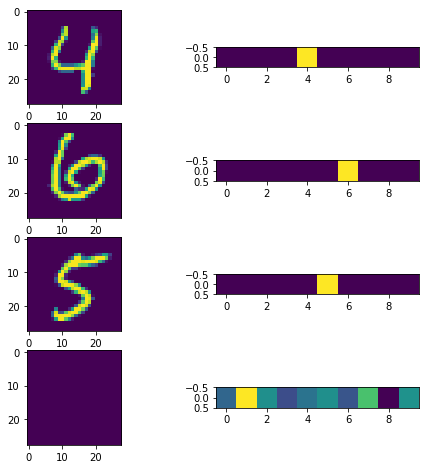

In [112]:
fig = plt.figure(figsize=(8,8))
columns = 2
rows = 4
        
fig.add_subplot(rows, columns, 1)
plt.imshow(test_images[0].squeeze())
fig.add_subplot(rows, columns, 2)
plt.imshow(model.predict(test_images[0].reshape(1,28,28,1)))

fig.add_subplot(rows, columns, 3)
plt.imshow(test_images[1].squeeze())
fig.add_subplot(rows, columns, 4)
plt.imshow(model.predict(test_images[1].reshape(1,28,28,1)))

fig.add_subplot(rows, columns, 5)
plt.imshow(test_images[2].squeeze())
fig.add_subplot(rows, columns, 6)
plt.imshow(model.predict(test_images[2].reshape(1,28,28,1)))

fig.add_subplot(rows, columns, 7)
plt.imshow(test_images[3].squeeze())
fig.add_subplot(rows, columns, 8)
plt.imshow(model.predict(test_images[3].reshape(1,28,28,1)))

In [113]:
# concat to from a large image
test_whole_first = np.concatenate([test_images[0], test_images[1]],axis=1)
test_whole_second = np.concatenate([test_images[2], test_images[3]],axis=1)
test_whole = np.concatenate([test_whole_first, test_whole_second],axis=0)

In [114]:
test_whole.shape

(56, 56, 1)

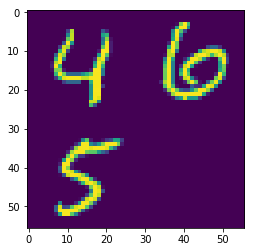

In [115]:
plt.imshow(test_whole.squeeze())

In [125]:
# make prediction using the fully convolutional network
res = model2.predict(test_whole.reshape(1,56,56,1)).squeeze()

In [131]:
res[:,:,0].shape

(15, 15)

Heat map for ten classes


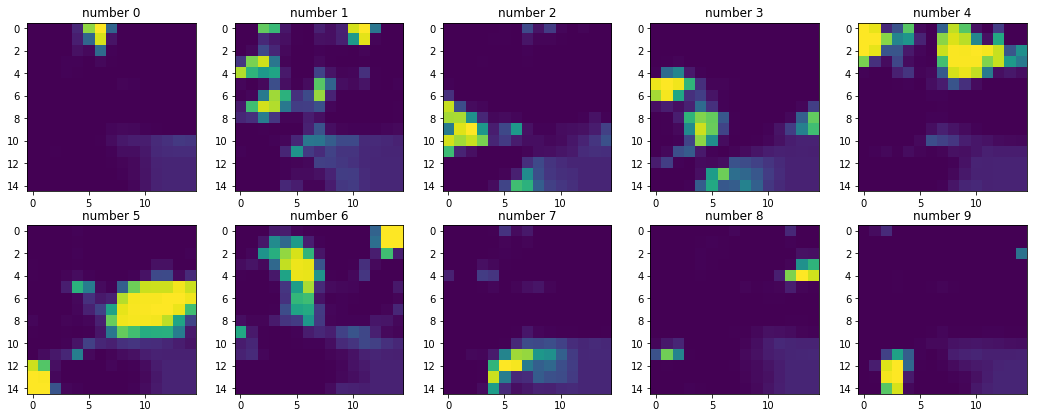

In [135]:
fig = plt.figure(figsize=(18,18))
columns = 5
rows = 5
for i in range(1, 11):
    fig.add_subplot(rows, columns, i)
    plt.imshow(res[:,:,i-1])
    plt.title("number " + str(i-1))
print("Heat map for ten classes")
plt.show()

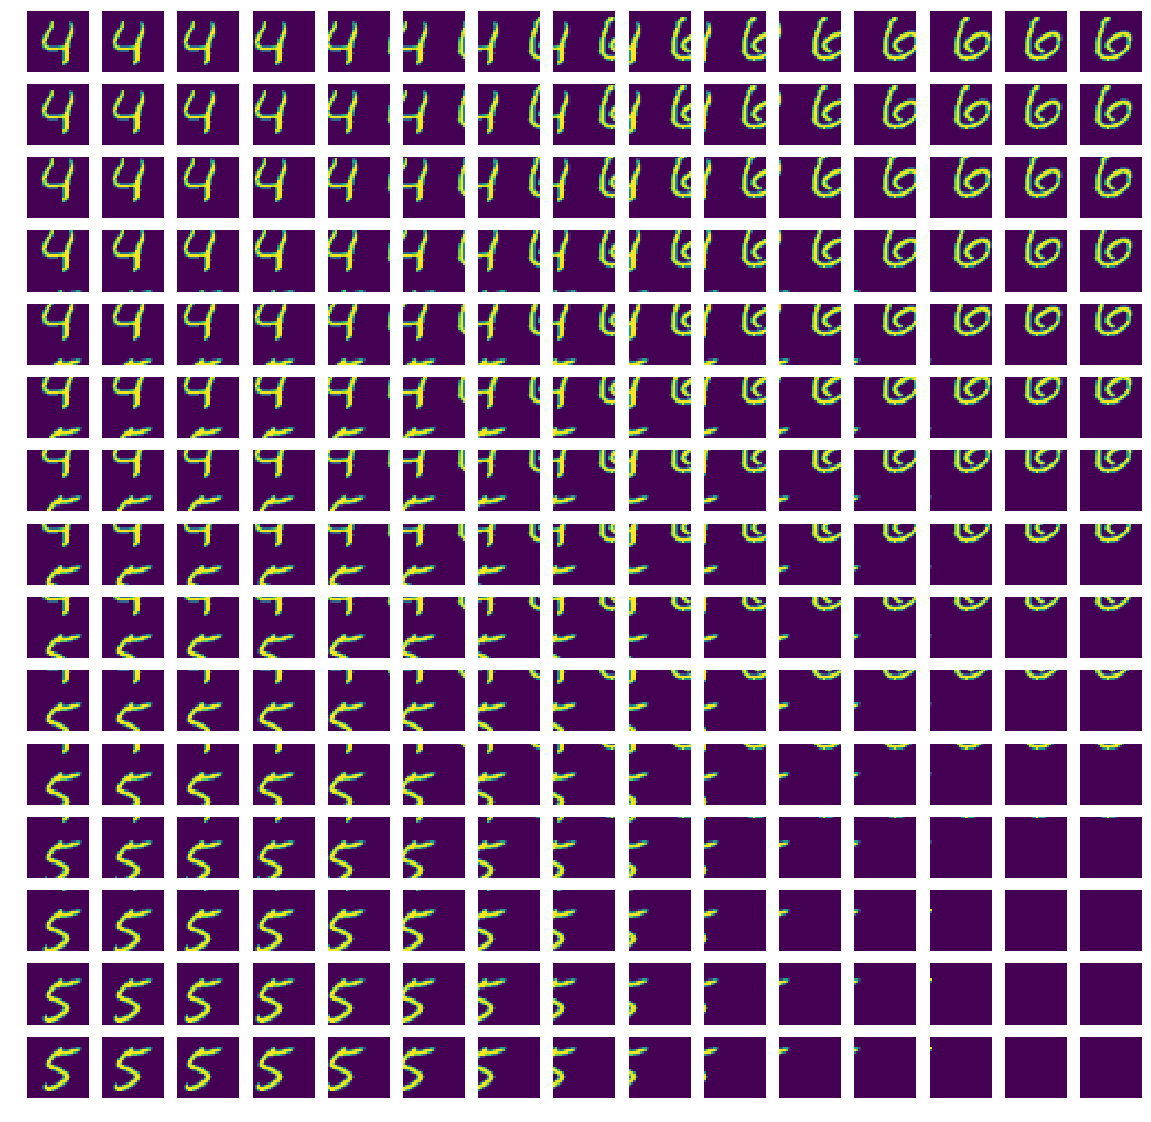

In [148]:
fig = plt.figure(figsize=(20,20))
columns = 15
rows = 15
count = 1
for i in range(0, 15):
    for j in range(0, 15):
        fig.add_subplot(rows, columns, count)
        count += 1
        plt.imshow(test_whole[i*2:28+i*2,j*2:28+j*2,:].squeeze())
        plt.axis('off')
        fig.add_subplot
plt.show()

In [144]:
res[0,0,:]

array([  2.03209254e-08,   6.59398779e-07,   3.52367550e-07,
         1.87086741e-07,   9.99742568e-01,   2.47504204e-08,
         1.03997856e-07,   1.52770554e-06,   1.84363114e-06,
         2.52702768e-04], dtype=float32)